# ALOS 2 - Global Mosaic  

This notebook contains general information about the alos 2 and demonstrates how to retrieve and visualise indexed the ALOS 2 global mosaic products.

## The Radar Wavelength

Synthetic  Aperture  Radar,  SAR,  is  an  active  system  operating  in  the  microwave  domain  of  the electromagnetic  spectrum.  Microwaves  are  not  visible  to  the  human  eye  and  provide  a  very different view of the world from what we are used to. 

While optical remote sensing sensors function similar to the human eye –they are passive sensors which record reflected sunlight –a radar sensor operates more like a flash camera in a dark room. The radar emits a light pulse and records the part of the pulse that is reflected, or scattered, back to the  sensor  (hence  the  term  backscatter).  Unlike  sunlight  which  is  non-polarised  and  comprises  a large range of different wavelengths, the radar is a laser which operates within narrowandwell-defined wavelength bands, and at a specific polarisation.

## About the ALOS Missions

The Japanese Earth observing satellite program run by JAXA (Japan Aerospace Exploration Agency) consists of two series of sensor types: those satellites used for atmospheric and marine observation, and those used mainly for land observation. The Advanced Land Observing Satellite (ALOS) mission utilizes advanced land-observing technology for cartography, regional observation, disaster monitoring, and resource surveying.

The PALSAR-2 aboard the ALOS-2 is a Synthetic Aperture Radar (SAR), which emits microwave and receives the reflection from the ground to acquire information. Since it does not need other sources of light such as the sun, SAR has the advantage of providing satellite images regardless day or night. The frequency of transmitting and receiving microwave is L-band, which is less affected by clouds and rains. This all-weather observing capability is suitable for monitoring disasters rapidly. In addition, L-band microwave can reach to the ground partially penetrating through vegetation to obtain information of vegetation and ground surface.


### Global Yearly Mosaic.

The global 25m resolution PALSAR/PALSAR-2 mosaic is a seamless global SAR image created by mosaicking SAR images of backscattering coefficient measured by PALSAR/PALSAR-2, where all the path within 10x10 degrees in latitude and longitude are
path processed and mosaicked for the sake of processing efficiency. Correction of geometric 2 distortion specific to SAR (ortho-rectification) and topographic effects on image intensity (slope correction) are applied to make forest classification easy. The size of one pixel is approximately 25 meter by 25 meter.

<img src="images/World_Mosaic_ALOS2.jpg">
Figure 1. The ALOS global mosaic combining ALOS and ALOS 2 sensors.

### Let's explore further by loading data. 


### Import modules 
You can execute a cell by clicking on it and pushing control+enter

In [2]:
%matplotlib notebook
import datacube # Load the datacube library
import datetime
import numpy as np
import json
import matplotlib.pyplot as plt

def figure_ratio(ds, fixed_width = 20):
    width = fixed_width
    height = len(ds.y) * (fixed_width / len(ds.x))
    return (width, height)


def callback(event):
    global pX, pY
    pX, pY = int(event.xdata + 0.5), int(event.ydata + 0.5)



### Available ALOS products
The `list_products` method in the Datacube class displays the names and details of all available products. In the below cell we will query what ALOS products are currently indexed in our instance.

In [3]:
# Connect to a datacube
dc = datacube.Datacube(app='Intro to ALOS')

# List metadata for all Landsat NBAR and NBART products available in DEA
dc_products = dc.list_products()
display_columns = ['name', 'description', 'product_type', 'crs', 'resolution', 'spatial_dimensions']
dc_products[dc_products['name'].str.contains("alos|alos")][display_columns].set_index('name')


,description,product_type,crs,resolution,spatial_dimensions
name,,,,,
alos2_palsar_AMA_ingest,ALOS-2 PALSAR mosaic tiles generated for use i...,gamma0,NaN,NaN,NaN


### Let's explore what measurement sensors we can access through the ODC.

In [4]:
# List metadata for all Landsat NBAR and NBART products available in DEA
dc_measurements = dc.list_measurements()
dc_measurements = dc_measurements.reset_index()
dc_measurements[dc_measurements['product'].str.contains("alos|alos")]

,product,measurement,aliases,dtype,flags_definition,name,nodata,units
0,alos2_palsar_AMA_ingest,hh,NaN,int16,NaN,hh,0,DN
1,alos2_palsar_AMA_ingest,hv,NaN,int16,NaN,hv,0,DN
2,alos2_palsar_AMA_ingest,date,NaN,int16,NaN,date,0,1
3,alos2_palsar_AMA_ingest,incidence_angle,NaN,uint8,NaN,incidence_angle,0,1
4,alos2_palsar_AMA_ingest,mask,NaN,uint8,"{'cloud_confidence': {'bits': [0, 1, 2, 3, 4, ...",mask,0,1


## L-Band Measurement Sensor Data

## Direct Back scatter (HH & HV)
The HH and HV measure direct backscatter, it occurs when the transmitted L-Band signal is reflected directly back to the sensor by a single reflection, by a surface oriented perpendicular to the radar illumination direction. It results in a strong co-polarisation (HH or VV) reflection and appears bright in the SAR image. Rock outcrops or bare mountain slopes oriented towards the radar can produce direct backscattering. At the short C-band wavelength, also the leaves in a dense vegetation canopy can cause direct scattering

<img src="images/Direct_Back_Scatter.jpg">
Figure 2. Example of direct back scatter.

### Horizontal and Vertical Polarisation.

The strength of direct back scatter is measured in polarisation, current spaceborne radar systems operate with linear polarisation, where the radar signals are transmitted and recieved at horizontal (H) and/or (V) polarisation.

The first two bands of the mosaic is back scatter, and in the case of the Alos 2 Global Mosaic product there are two types of back scatter measurents,

HH: Transmission of horizontal wave; Reception of horizontal component.

HV: Horizontal transmission; Recpetion of Vertical component,

<img src="images/lin_vert.big.gif">
Figure 3. Vertical Polarisation
<img src="images/lin_horiz.big.gif">
Figure 4. Horizontal Polarisation


### DN Units

Data are stored as digital number (DN) in unsigned 16 bit. The DN values can be converted to gamma naught values in decibel unit (dB) using the following equation:
0 = 10 log10〈𝐷𝑁2〉 + 𝐶𝐹

where, CF is a calibration factor, and <> is the ensemble averaging. 
The CF values are “-83.0 dB” for the PALSAR-2/PALSAR mosaic and “-84.66 dB” for the JERS-1 SAR mosaic.

This means that the final converstion is,

<img src="images/DN.png">

Let's explore the direct back scatter data over a Columbian rain forest.


In [5]:
#Load data into the cube

#Full Scene
#x = [-75, -74] 
#y = [1.00018083, 2]

#Smaller extent.
x = [-74.65, -74.85] 
y = [1.25, 1.08]

data_cube = dc.load(product='alos2_palsar_AMA_ingest',output_crs='epsg:32618', resolution=(-30, 30), x = x, y = y, measurements = ('hh','hv'))
data_cube

<xarray.Dataset>
Dimensions:  (time: 2, x: 743, y: 627)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2016-01-01
  * y        (y) float64 1.382e+05 1.381e+05 1.381e+05 1.381e+05 1.38e+05 ...
  * x        (x) float64 5.167e+05 5.167e+05 5.167e+05 5.168e+05 5.168e+05 ...
Data variables:
    hh       (time, y, x) int16 5789 6645 4214 4214 5340 4522 5358 5332 8406 ...
    hv       (time, y, x) int16 2549 1867 1945 1945 3002 1779 1342 1730 3204 ...
Attributes:
    crs:      epsg:32618

### Let's plot the direct back scatter.
To do so we first convert the digital number to dB (decibals).
Both polarisation bands will uniquely respond to the physical structure of a target, the vertical stems and horizontal ground surface give to rise to a strong double-bounce reflection which produces an extremely high HH back scatter response. For example HV will penetrate the forest canopy and provide brighter polarisation on vertical strutures such as forest. 

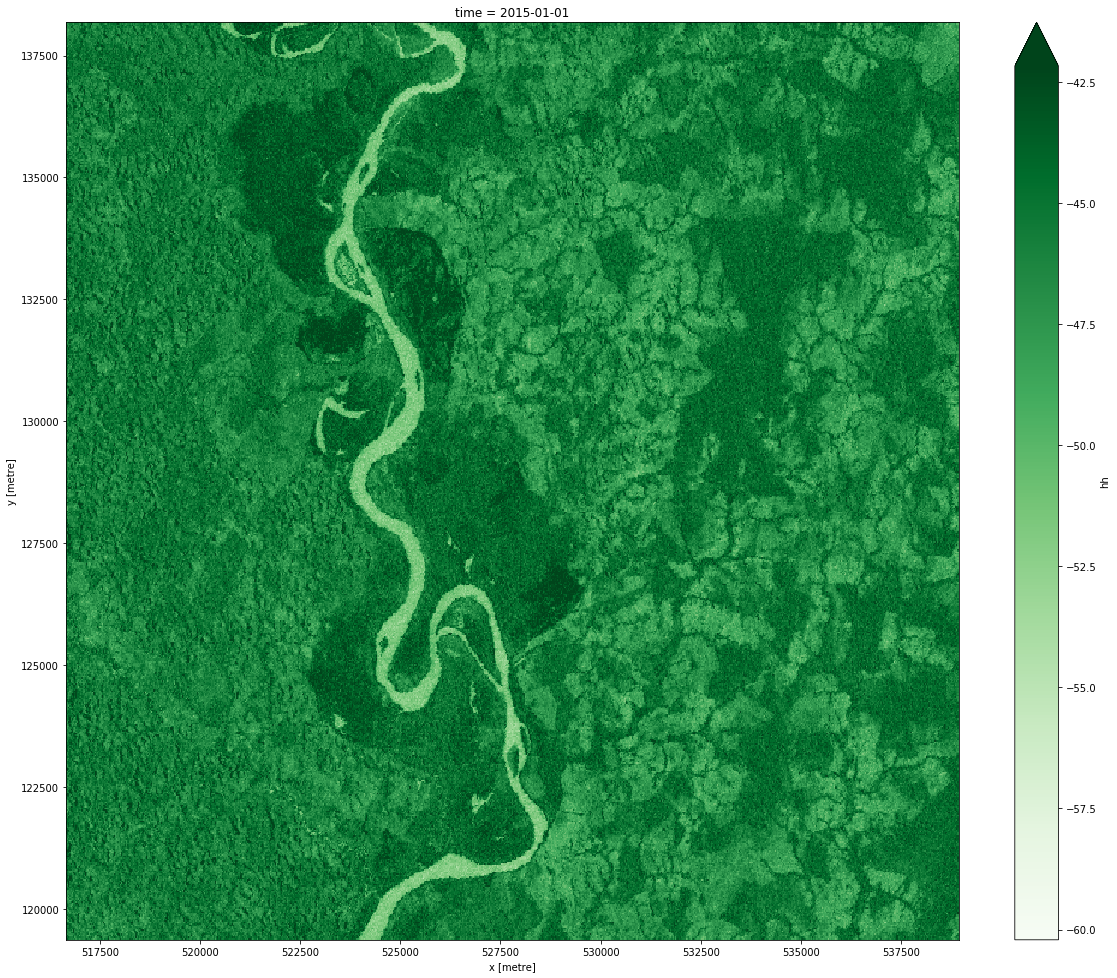

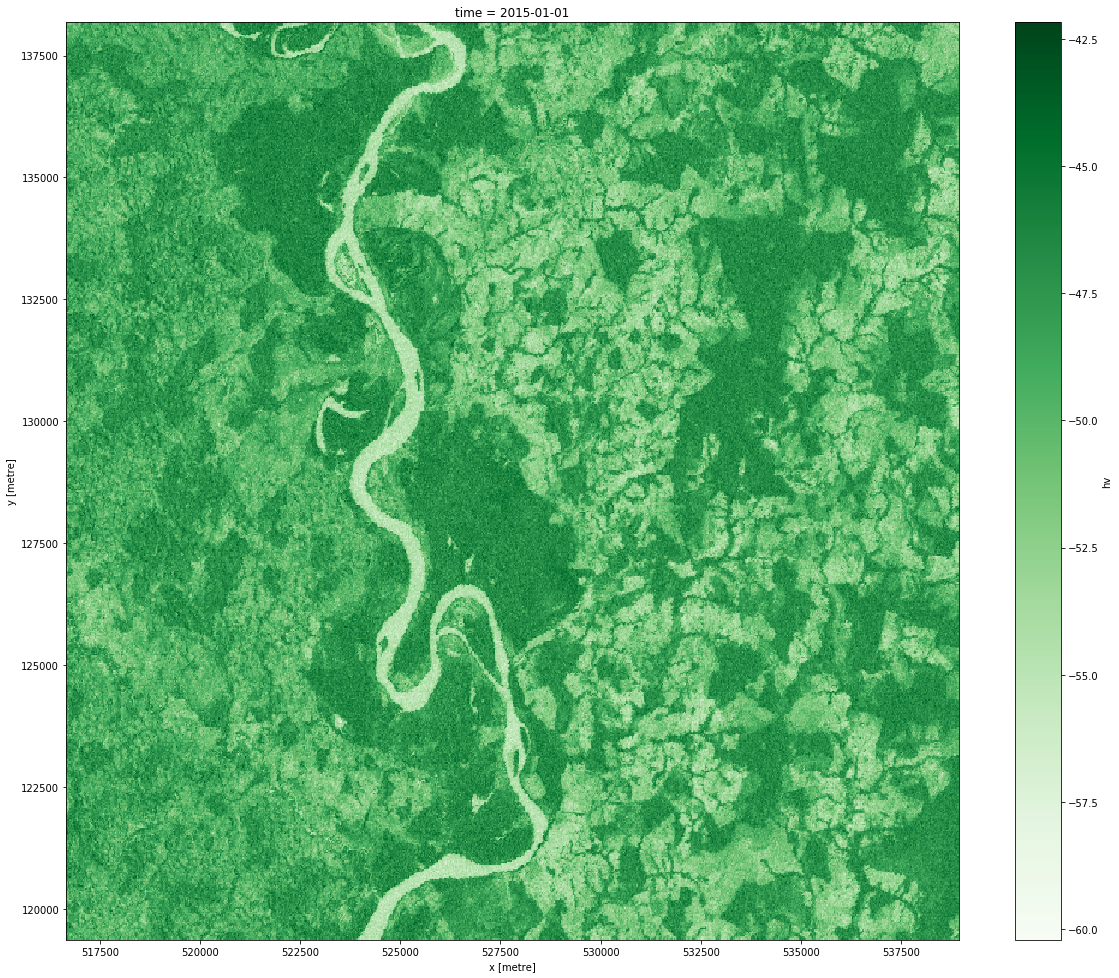

In [6]:
%matplotlib inline

#processed to DN to DB and visualise both
db_hh_hv = 10 * np.log10(data_cube) - 83
db_hh_hv['ratio'] = (db_hh_hv.hh / db_hh_hv.hv)

first_slice = db_hh_hv.isel(time = 0) # iselect selects by index, rather than value.

#Get the min and max of all your data
_min, _max = db_hh_hv.min(), db_hh_hv.max()

p_min = np.min([_min.hh.values,_min.hv.values])
p_max = np.min([_max.hh.values,_max.hv.values])

first_slice.hh.plot(cmap = "Greens",figsize = figure_ratio(first_slice),vmin = p_min, vmax = p_max)
first_slice.hv.plot(cmap = "Greens",figsize = figure_ratio(first_slice), vmin = p_min, vmax = p_max)


Change over time, lets explore vegetation change, we going to set the baseline year HV band from 2015 as the RED band and GREEN+BLUE to the analysis year in this case 2016.

Vegetation loss appears in RED and regrowth in CYAN. Areas of no change appear in different shades of GRAY. Users can change the RGB color assignments and bands (HH, HV) in the code below

In [ ]:
%matplotlib inline

rgb = np.stack([db_hh_hv.isel(time = 0).hv,
               db_hh_hv.isel(time = 1).hv,
              db_hh_hv.isel(time = 1).hv], axis = -1)

min_rgb = np.nanmin(rgb) 
max_rgb = np.nanmax(rgb) 
rgb = np.interp(rgb, (min_rgb, max_rgb), [1,255])
rgb = rgb.astype(int)
plt.figure(figsize = (15,15))
plt.imshow(rgb)


Reference 
https://www.eorc.jaxa.jp/ALOS/en/palsar_fnf/DatasetDescription_PALSAR2_Mosaic_FNF_revH.pdf
http://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf
    